In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class flex_channel_CNN(nn.Module):
    def __init__(self, output_channel = 1, width = 64 , height = 64 , ks = 3 ):
        super(flex_channel_CNN, self).__init__()
        # 定义单个通道的卷积网络
        self.extract_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding='same')
        self.feature2kernel = nn.Linear(width*height,ks * ks * output_channel)
        self.output_channel = output_channel
        self.ks = ks
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        outputs = []

        for i in range(channels):
          single_channel = x[:, i:i+1, :, :]  # extract single feature
          channel_feature = self.extract_conv(single_channel)
          channel_feature = torch.relu(channel_feature)
          channel_feature = channel_feature.view(batch_size, -1)  # flatten
          per_channel_kernel = self.feature2kernel(channel_feature)
          per_channel_kernel = torch.relu(per_channel_kernel)
          per_channel_kernel = per_channel_kernel.view(batch_size ,self.output_channel, 1 , self.ks , self.ks)
          outputs.append(per_channel_kernel)

        stack_kernel = torch.cat(outputs , dim = 2)
        # 這邊寫根據 batch進行personal的kerenl 運算
        feature_map_list =  []
        for img_num in range(batch_size) :
          single_img = x[img_num , : ,: ,: ]
          #print("Single img shape")
          #print(single_img.shape)
          kernel =  stack_kernel[img_num].squeeze(0)

          feature_map = F.conv2d(single_img,kernel,stride=(1,1),padding = 'same')
          feature_map = torch.relu(feature_map)
          feature_map = feature_map.unsqueeze(0)
          feature_map_list.append(feature_map)

        return_data = torch.cat(feature_map_list,dim = 0)

        return return_data

In [2]:
# 我的module確實可以處理不定通道數的輸入

input_tensor = torch.randn(7, 9, 128, 128).to('cuda')
flex_channel_CNN_model = flex_channel_CNN(output_channel=10,width=128,height=128)
#summary(model, input_size=(1, 3, 128, 128))
flex_channel_CNN_model.to('cuda')
output = flex_channel_CNN_model(input_tensor)
print(output.shape)

torch.Size([7, 10, 128, 128])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Question1_CNN(nn.Module):
    def __init__(self):
        super(Question1_CNN, self).__init__()
        # 第一個卷積層
        self.flex_layer = flex_channel_CNN(output_channel=16,width=128,height=128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二個卷積層，輸入維度等於輸出維度
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        
        # 第三個卷積層
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        # 全連接層
        self.fc1 = nn.Linear(32 * 14 * 14, 128)  # 假設最終展平后的特征圖尺寸為7x7
        self.fc2 = nn.Linear(128, 50)

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.flex_layer(x)))  # 第一個卷積層 + 池化
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))  # 第二個卷積層 + 池化
        x = self.pool(F.relu(self.conv2(x)))  # 第三個卷積層 + 池化
        #print(x.shape)
        x = x.view(-1, 32 * 14 * 14)  # 展平層
        x = F.relu(self.fc1(x))  # 全連接層
        x = self.fc2(x)  # 輸出層
        return x

# 創建模型實例
model = Question1_CNN()

# 打印模型結構
print(model)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Question1_CNN(
  (flex_layer): flex_channel_CNN(
    (extract_conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (feature2kernel): Linear(in_features=16384, out_features=144, bias=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
)


In [4]:
import os
input_tensor = torch.randn(7, 3, 128, 128).to('cuda')
#summary(model, input_size=(1, 3, 128, 128))
model.to('cuda')
output = model(input_tensor)
print(output.shape)

torch.Size([7, 50])


In [5]:
def get_path_and_label(path):
  image_list = []
  label_list = []

  with open(path , 'r') as file:
    for line in file :
      text_list = line.split(' ')
      file_path = os.path.join('/home/Dataset',text_list[0])
      label = int(text_list[1])

      image_list.append(file_path)
      label_list.append(label)

  return image_list , label_list

In [6]:
train_txt_path = '/home/Dataset/train.txt'
test_txt_path = '/home/Dataset/test.txt'
val_txt_path = '/home/Dataset/val.txt'

train_img , train_label = get_path_and_label(train_txt_path)
test_img , test_label = get_path_and_label(test_txt_path)
val_img , val_label = get_path_and_label(val_txt_path)

print(f"Len of train_img {len(train_img)} ")
print(f"Len of train_label {len(train_label)}")

print(f"Len of val_img {len(val_img)}")
print(f"Len of val_label {len(val_label)}")

print(f"Len of test_img {len(test_img)}")
print(f"Len of test_label {len(test_label)}")

Len of train_img 63325 
Len of train_label 63325
Len of val_img 450
Len of val_label 450
Len of test_img 450
Len of test_label 450


In [7]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, img_path_list , img_label_list , transform=None, target_transform=None):
        self.img_path_list = img_path_list
        self.img_label_list  = img_label_list
        self.transform = transforms.Compose([transforms.Resize(size=((128,128)))])

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        image = read_image(self.img_path_list[idx])
        image = self.transform(image)
        if image.shape[0] == 1 :
          image = image.repeat(3,1,1)
        image = image.float() / 255.0
        label = self.img_label_list[idx]

        return image, label

In [9]:
train_dataset = CustomImageDataset(train_img , train_label )
val_dataset = CustomImageDataset(val_img , val_label)
test_dataset = CustomImageDataset(test_img , test_label )
from torch.utils.data import DataLoader
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size = BATCH_SIZE , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
import torch.optim as optim
model = Question1_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [11]:
def calculate_accuracy(output, labels):

    preds = torch.argmax(output, dim=1)

    correct = torch.eq(preds, labels).sum().item()

    total = preds.shape[0]

    return correct , total

  0%|          | 0/495 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4/4 [00:00<00:00,  9.90it/s]


Epoch 0 training loss 0.028544125491058312 val loss 0.029919337696499293
Epoch 0 training accuracy 0.07586261350177655 val accuracy 0.14


100%|██████████| 4/4 [00:00<00:00, 10.51it/s]


Epoch 1 training loss 0.025231362816094883 val loss 0.028440779580010307
Epoch 1 training accuracy 0.15388866956178446 val accuracy 0.1511111111111111


100%|██████████| 4/4 [00:00<00:00, 10.50it/s]


Epoch 2 training loss 0.023432261293413515 val loss 0.028446212344699434
Epoch 2 training accuracy 0.20369522305566523 val accuracy 0.19777777777777777


100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


Epoch 3 training loss 0.021485936021409486 val loss 0.029129820929633246
Epoch 3 training accuracy 0.2577339123568891 val accuracy 0.1711111111111111


100%|██████████| 4/4 [00:00<00:00, 10.52it/s]


Epoch 4 training loss 0.019160005834513955 val loss 0.029991904894510906
Epoch 4 training accuracy 0.3297749703908409 val accuracy 0.14888888888888888


100%|██████████| 4/4 [00:00<00:00, 10.58it/s]


Epoch 5 training loss 0.01668600836150316 val loss 0.03166933006710476
Epoch 5 training accuracy 0.4058428740623766 val accuracy 0.15777777777777777


100%|██████████| 4/4 [00:00<00:00, 10.40it/s]


Epoch 6 training loss 0.01437425225608395 val loss 0.037280380460951064
Epoch 6 training accuracy 0.4822266087643111 val accuracy 0.13555555555555557


100%|██████████| 4/4 [00:00<00:00, 10.53it/s]


Epoch 7 training loss 0.012334336739399666 val loss 0.04191159884134928
Epoch 7 training accuracy 0.5524358468219502 val accuracy 0.13333333333333333


100%|██████████| 4/4 [00:00<00:00, 10.56it/s]


Epoch 8 training loss 0.010626176690283474 val loss 0.04719180319044325
Epoch 8 training accuracy 0.6093328069482826 val accuracy 0.13111111111111112


100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch 9 training loss 0.00904479029994683 val loss 0.05247597164577908
Epoch 9 training accuracy 0.6665298065534939 val accuracy 0.1288888888888889


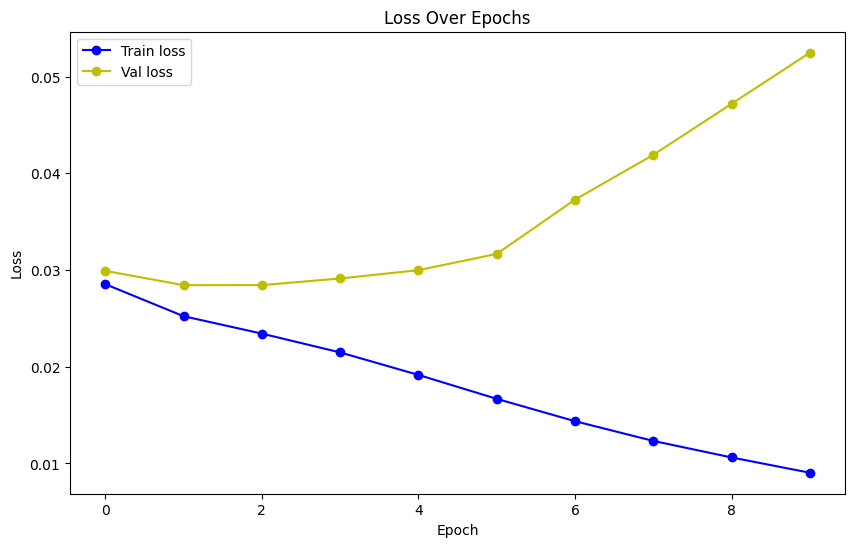

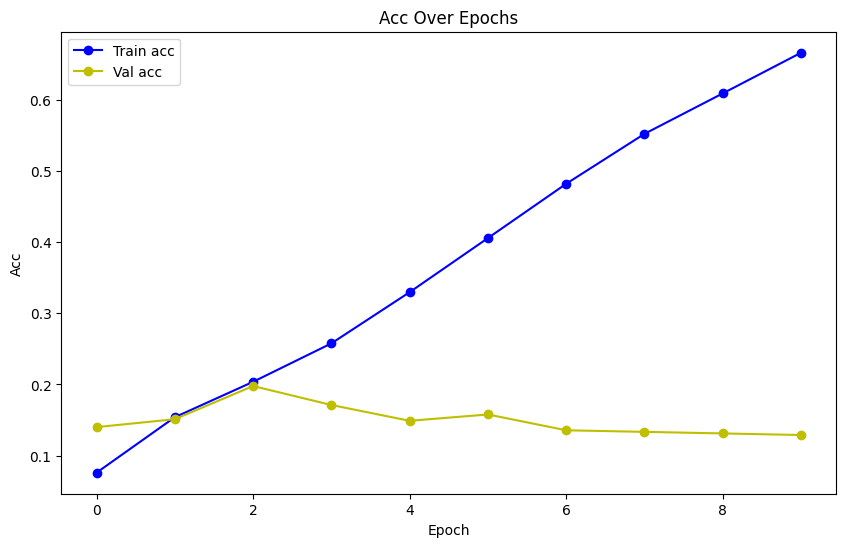

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCH = 10
training_loss_list = []
val_loss_list = []
training_accuracy_list = []
val_accuracy_list = []

for epoch in range(EPOCH) :
  training_loss = 0.0
  training_total_num = 0
  training_correct_num = 0
  val_loss = 0.0
  val_total_num = 0
  val_correct_num = 0
  model.train()
  for data in tqdm(train_dataloader) :
    img , label = data
    img = img.to(device)
    label = label.to(device)
    optimizer.zero_grad()

    outputs = model(img)
    #print(outputs[0])
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    training_correct_num += correct_num
    training_total_num += count

  model.eval()
  for data in tqdm(val_dataloader) :
    img , label = data
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)
    val_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    val_correct_num += correct_num
    val_total_num += count

  training_loss = training_loss/training_total_num
  val_loss = val_loss/val_total_num
  training_accuracy = training_correct_num/training_total_num
  val_accuracy = val_correct_num/val_total_num
  print(f"Epoch {epoch} training loss {training_loss} val loss {val_loss}")
  print(f"Epoch {epoch} training accuracy {training_accuracy} val accuracy {val_accuracy}")
  training_loss_list.append(training_loss)
  training_accuracy_list.append(training_accuracy)
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(training_loss_list, marker='o', linestyle='-', color='b' , label = 'Train loss')
plt.plot(val_loss_list, marker='o', linestyle='-', color='y', label = 'Val loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy_list, marker='o', linestyle='-', color='b' , label = 'Train acc')
plt.plot(val_accuracy_list, marker='o', linestyle='-', color='y', label = 'Val acc')
plt.title('Acc Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Layer_3_CNN(nn.Module):
    def __init__(self):
        super(Layer_3_CNN, self).__init__()
        # 第一個卷積層
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 輸入尺寸128x128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二個卷積層，輸入維度等於輸出維度
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        # 第三個卷積層
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        # 計算最終展平后的尺寸 (7x7)
        self.fc1_input_dim = 32 * 15 * 15  # 15x15是經過三個池化層後的尺寸
        
        # 全連接層
        self.fc1 = nn.Linear(self.fc1_input_dim, 128)
        self.fc2 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 第一個卷積層 + 池化 (64x64)
        x = self.pool(F.relu(self.conv2(x)))  # 第二個卷積層 + 池化 (32x32)
        x = self.pool(F.relu(self.conv3(x)))  # 第三個卷積層 + 池化 (15x15)
        #print(x.shape)
        x = x.view(-1, self.fc1_input_dim)  # 展平層
        x = F.relu(self.fc1(x))  # 全連接層
        x = self.fc2(x)  # 輸出層
        return x

# 創建模型實例
model = Layer_3_CNN()
model.to(device)
# 打印模型結構
print(model)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Layer_3_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=7200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
)


  0%|          | 0/495 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 10.91it/s]


Epoch 0 training loss 0.025835636796284887 val loss 0.026418974664476184
Epoch 0 training accuracy 0.12980655349388076 val accuracy 0.18444444444444444


100%|██████████| 4/4 [00:00<00:00, 10.56it/s]


Epoch 1 training loss 0.022558904550690168 val loss 0.02491879569159614
Epoch 1 training accuracy 0.2129490722463482 val accuracy 0.23333333333333334


100%|██████████| 4/4 [00:00<00:00, 10.98it/s]


Epoch 2 training loss 0.021421069421177084 val loss 0.02395930767059326
Epoch 2 training accuracy 0.24958547177260165 val accuracy 0.23777777777777778


100%|██████████| 4/4 [00:00<00:00, 10.64it/s]


Epoch 3 training loss 0.020509236686275828 val loss 0.02354495154486762
Epoch 3 training accuracy 0.27564153178049744 val accuracy 0.24222222222222223


100%|██████████| 4/4 [00:00<00:00, 10.93it/s]


Epoch 4 training loss 0.019801247566997228 val loss 0.023434252738952638
Epoch 4 training accuracy 0.2966285037504935 val accuracy 0.2822222222222222


100%|██████████| 4/4 [00:00<00:00, 10.97it/s]


Epoch 5 training loss 0.01915583168900253 val loss 0.02345740212334527
Epoch 5 training accuracy 0.3146624555862613 val accuracy 0.2911111111111111


100%|██████████| 4/4 [00:00<00:00, 10.77it/s]


Epoch 6 training loss 0.018574828813540056 val loss 0.02289815690782335
Epoch 6 training accuracy 0.33468614291354126 val accuracy 0.2577777777777778


100%|██████████| 4/4 [00:00<00:00, 10.38it/s]


Epoch 7 training loss 0.018031586115415794 val loss 0.02263368659549289
Epoch 7 training accuracy 0.34676667982629295 val accuracy 0.29555555555555557


100%|██████████| 4/4 [00:00<00:00, 10.84it/s]


Epoch 8 training loss 0.017504060610075783 val loss 0.02275755564371745
Epoch 8 training accuracy 0.3656533754441374 val accuracy 0.27111111111111114


100%|██████████| 4/4 [00:00<00:00, 10.58it/s]


Epoch 9 training loss 0.016972025618268903 val loss 0.023530550003051758
Epoch 9 training accuracy 0.3808764311093565 val accuracy 0.26


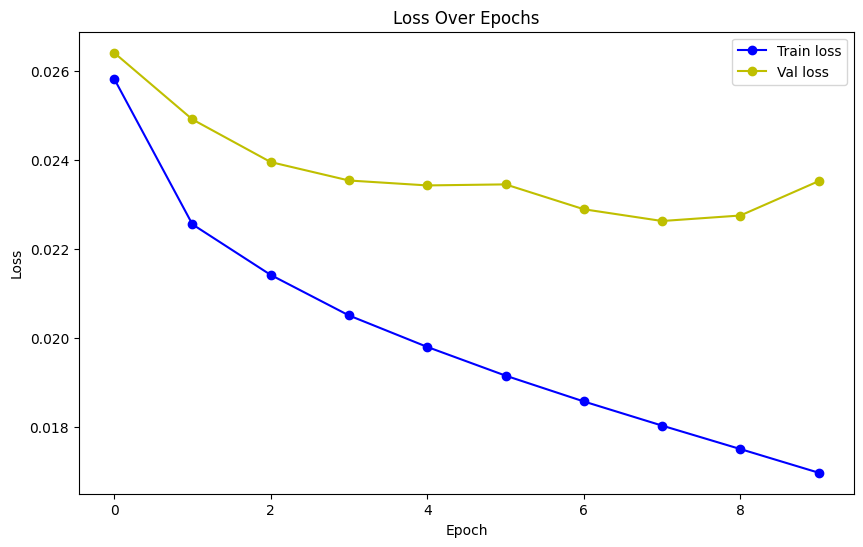

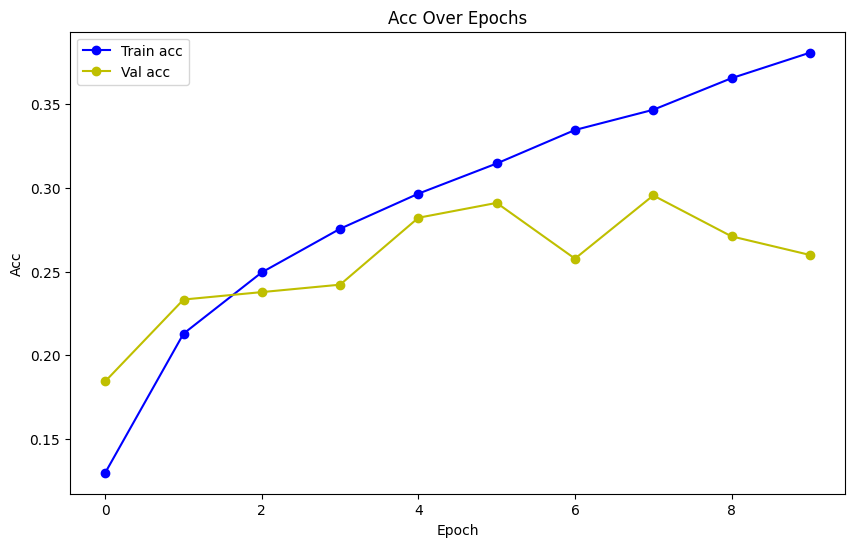

In [21]:
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCH = 10
training_loss_list = []
val_loss_list = []
training_accuracy_list = []
val_accuracy_list = []

for epoch in range(EPOCH) :
  training_loss = 0.0
  training_total_num = 0
  training_correct_num = 0
  val_loss = 0.0
  val_total_num = 0
  val_correct_num = 0
  model.train()
  for data in tqdm(train_dataloader) :
    img , label = data
    img = img.to(device)
    label = label.to(device)
    optimizer.zero_grad()

    outputs = model(img)
    #print(outputs[0])
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    training_correct_num += correct_num
    training_total_num += count

  model.eval()
  for data in tqdm(val_dataloader) :
    img , label = data
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)
    val_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    val_correct_num += correct_num
    val_total_num += count

  training_loss = training_loss/training_total_num
  val_loss = val_loss/val_total_num
  training_accuracy = training_correct_num/training_total_num
  val_accuracy = val_correct_num/val_total_num
  print(f"Epoch {epoch} training loss {training_loss} val loss {val_loss}")
  print(f"Epoch {epoch} training accuracy {training_accuracy} val accuracy {val_accuracy}")
  training_loss_list.append(training_loss)
  training_accuracy_list.append(training_accuracy)
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(training_loss_list, marker='o', linestyle='-', color='b' , label = 'Train loss')
plt.plot(val_loss_list, marker='o', linestyle='-', color='y', label = 'Val loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy_list, marker='o', linestyle='-', color='b' , label = 'Train acc')
plt.plot(val_accuracy_list, marker='o', linestyle='-', color='y', label = 'Val acc')
plt.title('Acc Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()